<a href="https://colab.research.google.com/github/pachterlab/LSCHWCP_2023/blob/main/Notebooks/Figure_2/Figure_2a/create_ref_taxonomic_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code to create the necessary files for this [iTOL tree](https://tinyurl.com/4dzwz5ny):
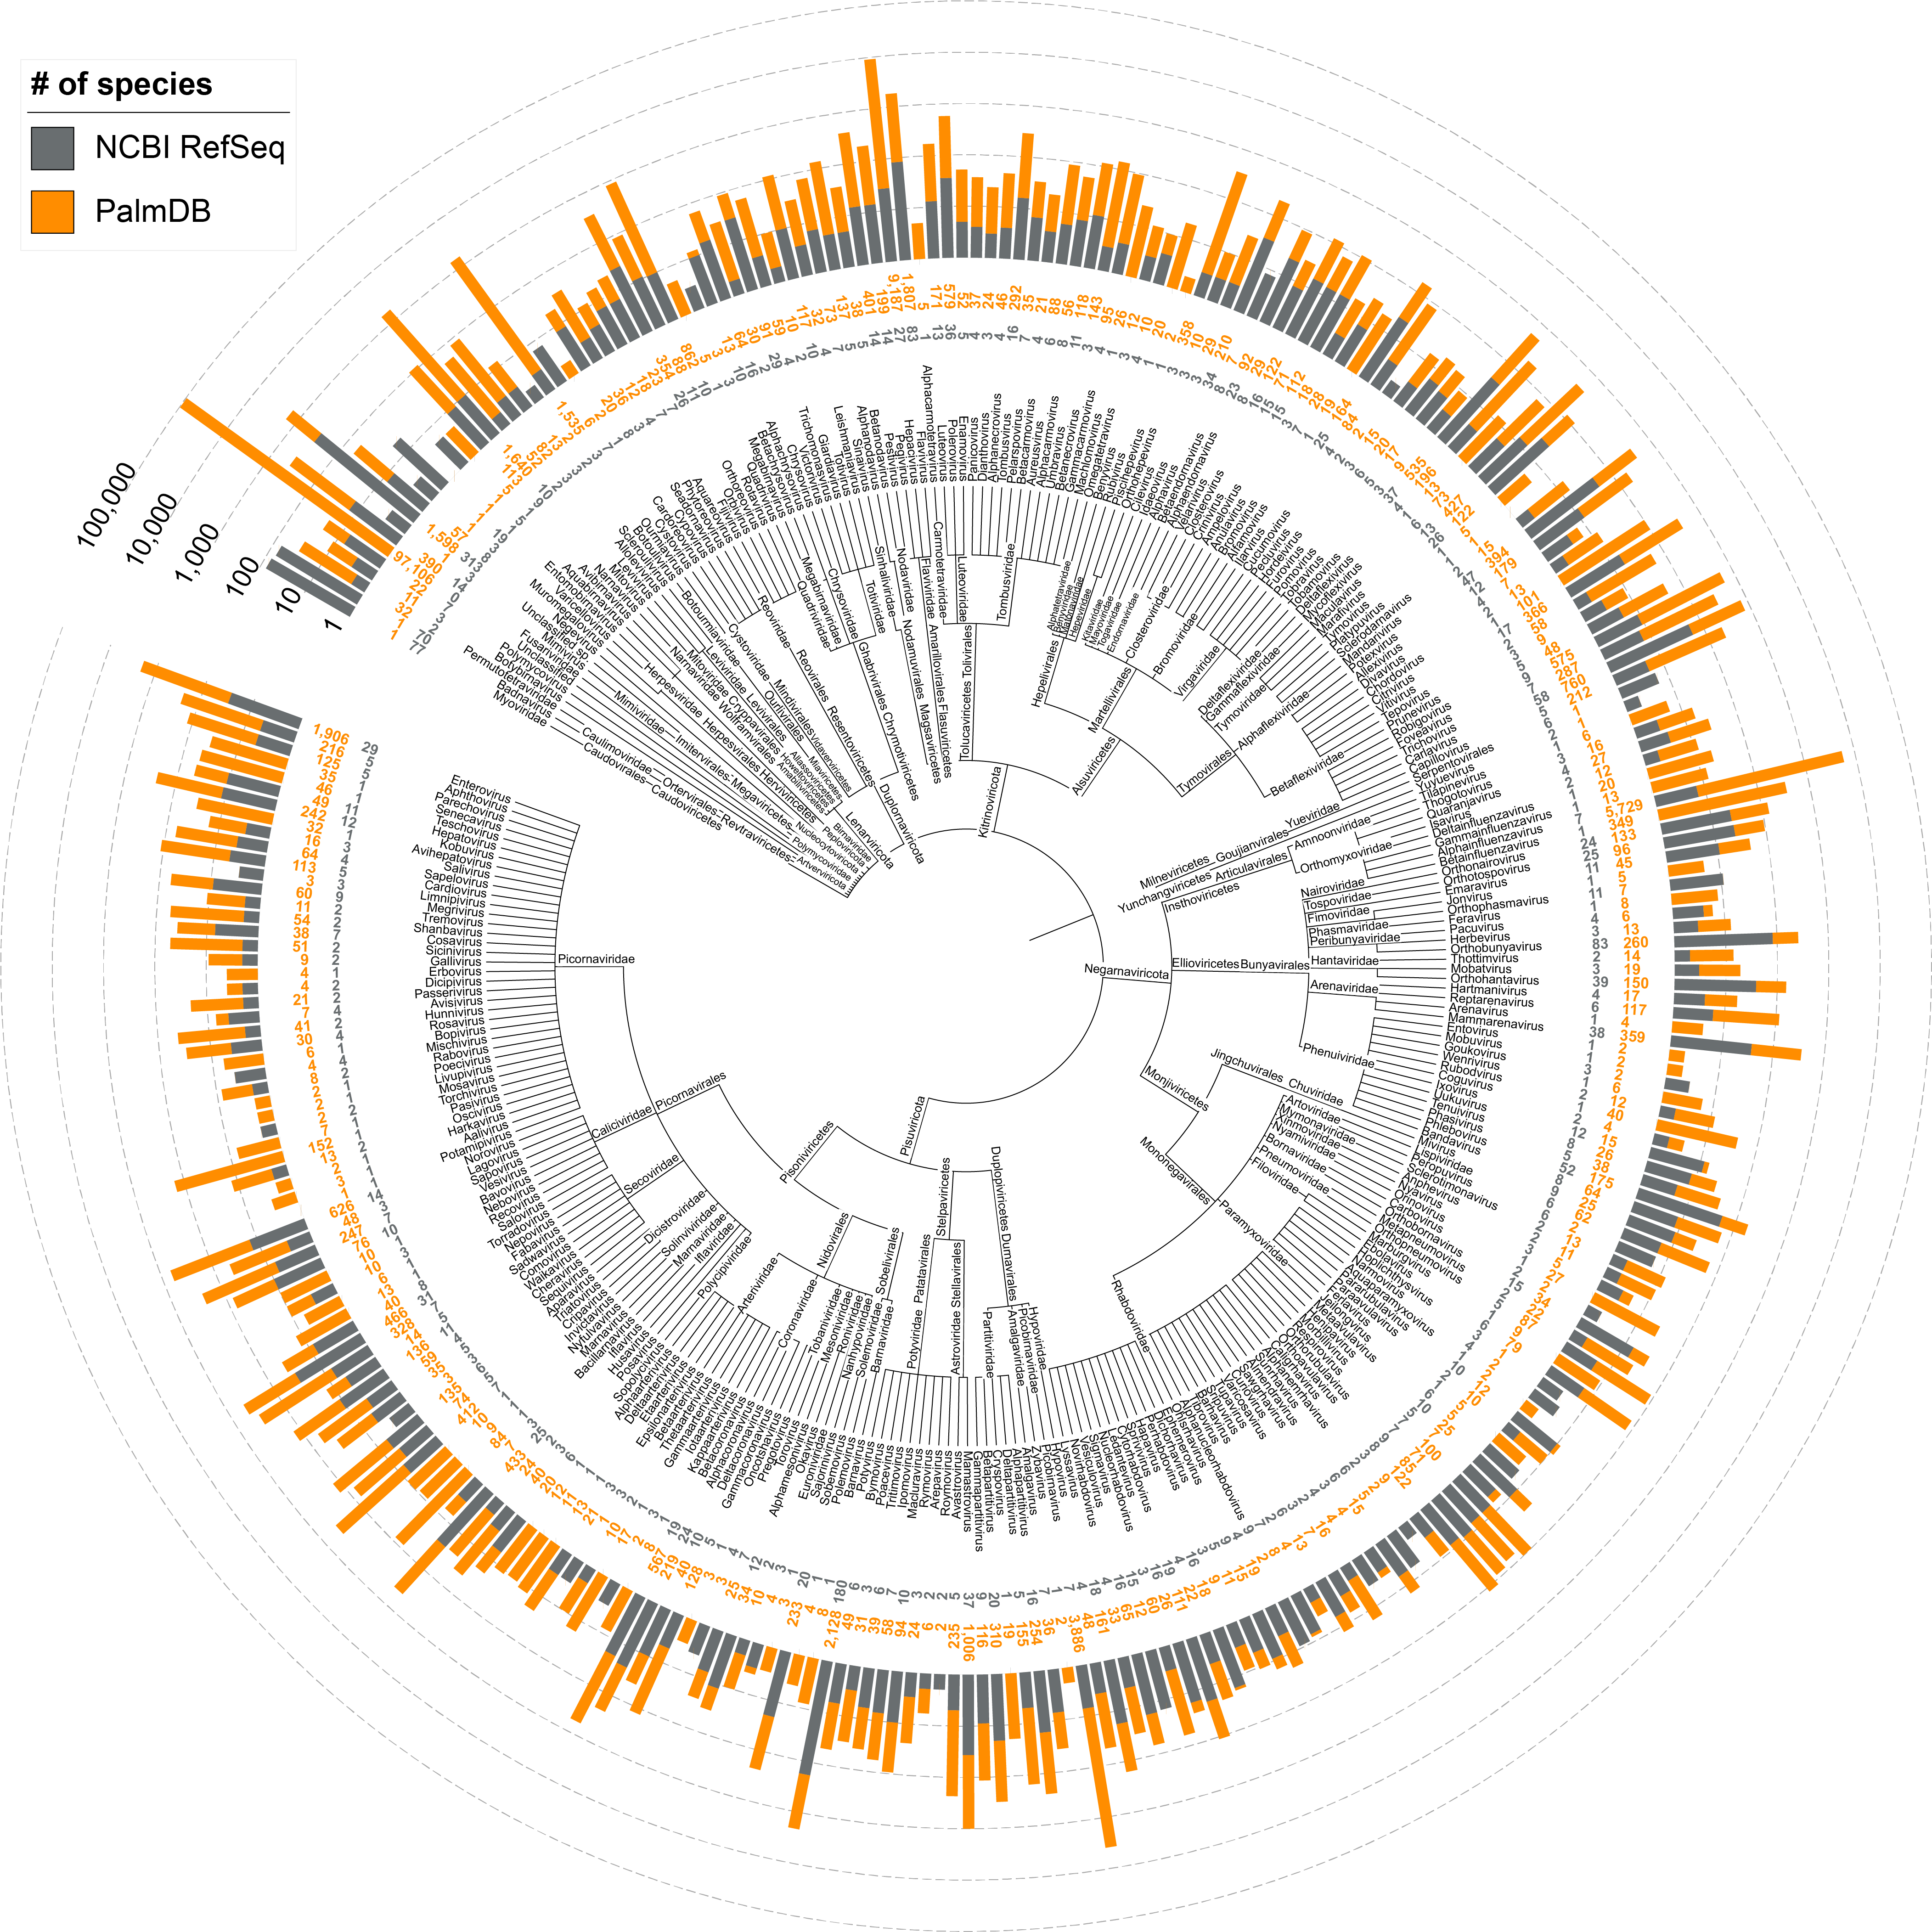

In [1]:
import pandas as pd

Download virus ID to taxonomy mapping:

In [2]:
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/ID_to_taxonomy_mapping.csv

--2023-12-07 21:15:14--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/ID_to_taxonomy_mapping.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19705497 (19M) [text/plain]
Saving to: ‘ID_to_taxonomy_mapping.csv’

ID_to_taxonomy_mapp 100%[===================>]  18.79M   120MB/s    in 0.2s    

2023-12-07 21:15:15 (120 MB/s) - ‘ID_to_taxonomy_mapping.csv’ saved [19705497/19705497]



In [3]:
palmdb = pd.read_csv("ID_to_taxonomy_mapping.csv")
# Only keep columns of interest here
palmdb = palmdb[["ID", "phylum", "class", "order", "family", "genus", "species"]]
palmdb

,ID,phylum,class,order,family,genus,species
0,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...
1,u10066,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...
2,u10121,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...
3,u10124,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...
4,u102609,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...
...,...,...,...,...,...,...,...
296556,u296608,.,.,.,.,.,.
296557,u296609,.,.,.,.,.,.
296558,u296613,.,.,.,.,.,.
296559,u296616,.,.,.,.,.,.


Add phylum "Unclassified" to all labels without classification and "Unclassified sp." labels with only species classified:

In [4]:
for index, row in palmdb.iterrows():
    if row["phylum"] == "." and row["class"] == "." and row["order"] == "." and row["family"] == "." and row["genus"] == ".":
        if row["species"] == ".":
            row["phylum"] = "Unclassified"
        else:
            row["phylum"] = "Unclassified sp."

In [5]:
palmdb[palmdb["phylum"] == "Unclassified sp."]

,ID,phylum,class,order,family,genus,species
9136,u1067,Unclassified sp.,.,.,.,.,Chronic bee paralysis virus
9137,u1250,Unclassified sp.,.,.,.,.,Chronic bee paralysis virus
9138,u14005,Unclassified sp.,.,.,.,.,Chronic bee paralysis virus
9139,u14340,Unclassified sp.,.,.,.,.,Chronic bee paralysis virus
9140,u14414,Unclassified sp.,.,.,.,.,Chronic bee paralysis virus
...,...,...,...,...,...,...,...
294814,u62292,Unclassified sp.,.,.,.,.,Beihai sipunculid worm virus 4
294815,u66874,Unclassified sp.,.,.,.,.,Beihai sipunculid worm virus 4
294816,u74834,Unclassified sp.,.,.,.,.,Beihai sipunculid worm virus 4
295659,u294010,Unclassified sp.,.,.,.,.,Hubei earwig virus 2


Make barplot showing number of viruses per phylum, class, order etc. and then overlay with how many of these can also be found in NCBI data.  

In [6]:
def df_to_dict(df):
    """
    Convert data frame to node_to_children dictionary as a first step to converting it to Newick format.

    Every row in the data frame (df) should stand for one complete branch of the tree from the root to the leaves in order
    from left to right.

    Returns formatted dictionary.

    Source:
    https://stackoverflow.com/questions/65017040/how-to-convert-pandas-dataframe-to-dictionary-for-newick-format
    """
    node_to_children = {}

    # Setting arbritrary branch length 1
    branch_length = 1

    # Iterate over dataframe row-wise, assuming that every row stands for one complete branch of the tree
    for row in df.itertuples():
        # Remove index at position 0 and elements that contain no child (".")
        row_list = [element for element in row[1:] if element != "."]

        for i in range(len(row_list)-1):
            if row_list[i] in node_to_children.keys():
                # Check if parent entry already existing
                if row_list[i+1] in node_to_children[row_list[i]].keys():
                    # If already exists --> next
                    continue
                else:
                    # If entry does not exist --> update dict and add the connection
                    node_to_children[row_list[i]].update({row_list[i+1]:branch_length})
            else:
                # Add the branching point
                node_to_children[row_list[i]] = {row_list[i+1]:branch_length}

    return node_to_children


def newickify(node_to_children, root_node) -> str:
    """
    Function to convert a dictionary to Newick format.

    Source:
    https://stackoverflow.com/questions/50003007/how-to-convert-python-dictionary-to-newick-form-format
    """
    # Setting arbritrary branch length 1
    branch_length = 1

    visited_nodes = set()

    def newick_render_node(name, distance: float) -> str:
        assert name not in visited_nodes, "Error: The tree may not be circular!"

        if name not in node_to_children:
            # Leafs
            return F'{name}:{distance}'
        else:
            # Nodes
            visited_nodes.add(name)
            children = node_to_children[name]
            children_strings = [newick_render_node(child, children[child]) for child in children.keys()]
            children_strings = ",".join(children_strings)
            return F'({children_strings}){name}:{distance}'

    newick_string = newick_render_node(root_node, branch_length) + ';'

    # Ensure no entries in the dictionary were left unused
    assert visited_nodes == set(node_to_children.keys()), "Error: some nodes aren't in the tree"

    return newick_string

Remove virus ID and species columns to create a clean tree:

In [7]:
# Remove non-relevent columns and change order of columns
phylogeny_data_clean = palmdb[["phylum", "class", "order", "family", "genus"]]

# Add "root" node
phylogeny_data_clean.insert(0, "root", "root")

## Convert data frame to node_to_children dictionary
node_to_children = df_to_dict(phylogeny_data_clean)

## Convert dictionary to Newick format
nw_string = newickify(node_to_children, root_node='root')

In [8]:
with open("palmdb_newick.txt", "w") as file:
    file.write(nw_string)

Use palmdb_newick.txt to create the [iTOL](https://itol.embl.de/) tree. Download the tree nodes from iTOL:

In [9]:
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/Notebooks/Figure_2/Figure_2a/tree_endnodes.csv

--2023-12-07 21:15:41--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/Notebooks/Figure_2/Figure_2a/tree_endnodes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8563 (8.4K) [text/plain]
Saving to: ‘tree_endnodes.csv’

tree_endnodes.csv   100%[===================>]   8.36K  --.-KB/s    in 0s      

2023-12-07 21:15:42 (62.9 MB/s) - ‘tree_endnodes.csv’ saved [8563/8563]



In [10]:
gtn = pd.read_csv("tree_endnodes.csv", sep=",", header=2)
gtn = gtn.drop("↓ ↓ INSERT YOUR DATA BELOW ↓ ↓", axis=1)
gtn

,Tree node ID,Tree node label
0,Negevirus,Negevirus
1,Unclassified sp.,Unclassified sp.
2,Fusariviridae,Fusariviridae
3,Unclassified,Unclassified
4,Botybirnavirus,Botybirnavirus
...,...,...
301,Pasivirus,Pasivirus
302,Oscivirus,Oscivirus
303,Harkavirus,Harkavirus
304,Aalivirus,Aalivirus


Add species counts in PalmDB database:

In [11]:
palmdb_sp_counts = []

for end_node in gtn["Tree node ID"].values:
    palmdb_sp_counts.append(len(palmdb[palmdb.isin([end_node]).any(axis=1)]))

gtn["palmdb_sp_count"] = palmdb_sp_counts
gtn

,Tree node ID,Tree node label,palmdb_sp_count
0,Negevirus,Negevirus,57
1,Unclassified sp.,Unclassified sp.,1598
2,Fusariviridae,Fusariviridae,390
3,Unclassified,Unclassified,97106
4,Botybirnavirus,Botybirnavirus,11
...,...,...,...
301,Pasivirus,Pasivirus,152
302,Oscivirus,Oscivirus,13
303,Harkavirus,Harkavirus,2
304,Aalivirus,Aalivirus,3


Species counts in NCBI/RefSeq (for the iTOL tree shown above and in the manuscript, the NCBI species counts were retrieved from http://www.virusite.org/index.php on 2023/03/28):

In [12]:
import requests
import time

In [13]:
ncbi_sp_counts = []
for end_node in gtn["Tree node ID"].values:
    time.sleep(1)
    # Note rows was set to 15000 to overwrite maximum of 25 results
    r = requests.get(f"http://www.virusite.org/index.php?nav=browse&query1={end_node}&field1=virus.name&expand=false&search_nav=virus&sort=name&order=asc&rows=15000&page=1")
    df_list = pd.read_html(r.content)
    df = df_list[-1]

    ncbi_sp_counts.append(len(df))

gtn["ncbi_sp_count"] = ncbi_sp_counts
gtn

,Tree node ID,Tree node label,palmdb_sp_count,ncbi_sp_count
0,Negevirus,Negevirus,57,8
1,Unclassified sp.,Unclassified sp.,1598,73
2,Fusariviridae,Fusariviridae,390,38
3,Unclassified,Unclassified,97106,73
4,Botybirnavirus,Botybirnavirus,11,3
...,...,...,...,...
301,Pasivirus,Pasivirus,152,1
302,Oscivirus,Oscivirus,13,2
303,Harkavirus,Harkavirus,2,1
304,Aalivirus,Aalivirus,3,1


Manually check the numbers of the "Unclassified" (0) and "Unclassified sp." (see below) endnotes for NCBI:

In [14]:
# Number of Unclassified sp. for NCBI
r = requests.get(f"http://www.virusite.org/index.php?nav=browse&query1=unclassified+viruses&field1=virus.name&expand=false&search_nav=virus&sort=name&order=asc&rows=15000&page=1")
df_list = pd.read_html(r.content)
df = df_list[-1]
len(df)

318

In [15]:
gtn.loc[gtn.index[gtn["Tree node ID"] == "Unclassified sp."][0], "ncbi_sp_count"] = len(df)

In [16]:
# Manually change "Unclassified" to 0
gtn.loc[gtn.index[gtn["Tree node ID"] == "Unclassified"][0], "ncbi_sp_count"] = 0

In [17]:
gtn

,Tree node ID,Tree node label,palmdb_sp_count,ncbi_sp_count
0,Negevirus,Negevirus,57,8
1,Unclassified sp.,Unclassified sp.,1598,318
2,Fusariviridae,Fusariviridae,390,38
3,Unclassified,Unclassified,97106,0
4,Botybirnavirus,Botybirnavirus,11,3
...,...,...,...,...
301,Pasivirus,Pasivirus,152,1
302,Oscivirus,Oscivirus,13,2
303,Harkavirus,Harkavirus,2,1
304,Aalivirus,Aalivirus,3,1


Log numbers:

In [18]:
from numpy import *

In [19]:
# Take log of values while masking 0s to keep them
gtn["palmdb_sp_count_log"] = ma.log(gtn["palmdb_sp_count"].values).filled(0)
gtn["ncbi_sp_count_log"] = ma.log(gtn["ncbi_sp_count"].values).filled(0)

In [20]:
gtn

,Tree node ID,Tree node label,palmdb_sp_count,ncbi_sp_count,palmdb_sp_count_log,ncbi_sp_count_log
0,Negevirus,Negevirus,57,8,4.043051,2.079442
1,Unclassified sp.,Unclassified sp.,1598,318,7.376508,5.762051
2,Fusariviridae,Fusariviridae,390,38,5.966147,3.637586
3,Unclassified,Unclassified,97106,0,11.483558,0.000000
4,Botybirnavirus,Botybirnavirus,11,3,2.397895,1.098612
...,...,...,...,...,...,...
301,Pasivirus,Pasivirus,152,1,5.023881,0.000000
302,Oscivirus,Oscivirus,13,2,2.564949,0.693147
303,Harkavirus,Harkavirus,2,1,0.693147,0.000000
304,Aalivirus,Aalivirus,3,1,1.098612,0.000000


In [21]:
# Substract the NCBI counts from the PalmDB since the bars will be on top of each other in the iTOL tree
gtn["palmdb_sp_count-ncbi_sp_count"] = gtn["palmdb_sp_count"] - gtn["ncbi_sp_count"]
gtn["palmdb_sp_count_log-ncbi_sp_count_log"] = gtn["palmdb_sp_count_log"] - gtn["ncbi_sp_count_log"]

In [22]:
gtn.to_csv("tree_endnodes_with_counts.csv")

Add the "ncbi_sp_count_log" and "palmdb_sp_count_log-ncbi_sp_count_log" (replacing all negative values with 0) to the iTOL tree.

___